In [ ]:
!pip install lightgbm

# Imports

In [1]:
# Módulos de manipulação de dados

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Módulos de DataPrep
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split

import warnings
warnings.filterwarnings('ignore')

# Modelos de regressão que iremos testar
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import  KNeighborsRegressor
from sklearn.svm import  SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Importando módulos de teste
from statsmodels.tsa.stattools import adfuller

/home/diolinux/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Carregamento dos Dados e Mudança do dtype de algumas features

In [2]:
# Carregando os dados para treinamento do modelo
dados_prep = pd.read_csv('2004-2021.tsv',sep='\t', encoding='utf-8', parse_dates=['DATA INICIAL', 'DATA FINAL'])


In [ ]:
dados_prep.head()

In [ ]:
dados_prep.info()

In [ ]:
print("Value of row 1903")
display(dados_prep.iloc[1903])

In [3]:
columns= ['PREÇO MÉDIO DISTRIBUIÇÃO', 'DESVIO PADRÃO DISTRIBUIÇÃO' ,'PREÇO MÍNIMO DISTRIBUIÇÃO','PREÇO MÁXIMO DISTRIBUIÇÃO','COEF DE VARIAÇÃO DISTRIBUIÇÃO' ,'MARGEM MÉDIA REVENDA' ]
for col in columns:
    dados_prep[col] = dados_prep[col].replace('-', 0)

In [4]:
columns= ['PREÇO MÉDIO DISTRIBUIÇÃO', 'DESVIO PADRÃO DISTRIBUIÇÃO' ,'PREÇO MÍNIMO DISTRIBUIÇÃO','PREÇO MÁXIMO DISTRIBUIÇÃO','COEF DE VARIAÇÃO DISTRIBUIÇÃO' ,'MARGEM MÉDIA REVENDA' ]
for col in columns:
    dados_prep[col] = pd.to_numeric(dados_prep[col])

In [5]:
columns= ['PREÇO MÉDIO DISTRIBUIÇÃO', 'DESVIO PADRÃO DISTRIBUIÇÃO' ,'PREÇO MÍNIMO DISTRIBUIÇÃO','PREÇO MÁXIMO DISTRIBUIÇÃO','COEF DE VARIAÇÃO DISTRIBUIÇÃO' ,'MARGEM MÉDIA REVENDA' ]
for col in columns:
    dados_prep[col] = dados_prep[col].replace(-99999.0, 0)

In [6]:
# Eliminando registros em que não temos a variável resposta
dados_prep = dados_prep.dropna(subset=['PREÇO MÉDIO REVENDA'])

print(dados_prep.isna().sum())

DATA INICIAL                     0
DATA FINAL                       0
REGIÃO                           0
ESTADO                           0
PRODUTO                          0
NÚMERO DE POSTOS PESQUISADOS     0
UNIDADE DE MEDIDA                0
PREÇO MÉDIO REVENDA              0
DESVIO PADRÃO REVENDA            0
PREÇO MÍNIMO REVENDA             0
PREÇO MÁXIMO REVENDA             0
MARGEM MÉDIA REVENDA             0
COEF DE VARIAÇÃO REVENDA         0
PREÇO MÉDIO DISTRIBUIÇÃO         0
DESVIO PADRÃO DISTRIBUIÇÃO       0
PREÇO MÍNIMO DISTRIBUIÇÃO        0
PREÇO MÁXIMO DISTRIBUIÇÃO        0
COEF DE VARIAÇÃO DISTRIBUIÇÃO    0
dtype: int64


# EDA

In [ ]:
plt.figure(figsize=(10,4))
sns.distplot(dados_prep['PREÇO MÉDIO REVENDA'])
plt.xlabel('PREÇO MÉDIO DE REVENDA',size=16)
plt.ylabel('Densidade',size=16)
plt.title('Distribuição da variável resposta',size=16)
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
sns.distplot(np.log1p(dados_prep['PREÇO MÉDIO REVENDA']))
plt.xlabel('PREÇO MÉDIO DE REVENDA',size=16)
plt.ylabel('Densidade',size=16)
plt.title('Distribuição do log da variável resposta',size=12)
plt.show()

In [7]:
dados_prep["PREÇO MÉDIO REVENDA"] = np.log(dados_prep["PREÇO MÉDIO REVENDA"] + 1)

In [ ]:
sns.displot(data=dados_prep, x="PREÇO MÉDIO REVENDA", kde=True)

In [ ]:
#dados_prep.set_index('DATA INICIAL',inplace=True)

In [ ]:
#dados_prep.set_index('DATA FINAL',inplace=True)

In [ ]:
# Observar a target ao longo do tempo
plt.figure(figsize=(30,4))
plt.plot(dados_prep['DATA FINAL'].dropna,dados_prep['PREÇO MÉDIO REVENDA'])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('PM 2.5',size=22)
plt.title('Histórico da target',size=22)

plt.show()

In [8]:
novo = dados_prep.query('ESTADO == "SAO PAULO" and PRODUTO == "GASOLINA COMUM"')

In [ ]:
novo.info()

In [ ]:
plt.figure(figsize=(30,4))
plt.plot(novo['DATA INICIAL'],novo['PREÇO MÉDIO REVENDA'])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('PM 2.5',size=22)
plt.title('Histórico da target',size=22)

plt.show()

In [ ]:
# Observar a target ao longo do tempo
plt.figure(figsize=(30,4))
plt.plot(novo['DATA FINAL'],novo['PREÇO MÉDIO REVENDA'])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('PM 2.5',size=22)
plt.title('Histórico da target',size=22)

plt.show()

In [ ]:
def constroi_features_defasadas(base,lista_features,defasagem_maxima):
    # Constrói features defasadas com base na base original
    # Copia a base
    base_cop = base.copy()
    for feat in lista_features:       
        for i in range(1,defasagem_maxima+1):
            base_cop[str(feat)+'_def_'+str(i)] = base_cop[feat].shift(i)
    return base_cop

In [ ]:
novo_eng = constroi_features_defasadas(novo,['PREÇO MÉDIO REVENDA', 'DESVIO PADRÃO REVENDA', 'PREÇO MÍNIMO REVENDA',
       'PREÇO MÁXIMO REVENDA', 'MARGEM MÉDIA REVENDA',
       'COEF DE VARIAÇÃO REVENDA', 'PREÇO MÉDIO DISTRIBUIÇÃO',
       'DESVIO PADRÃO DISTRIBUIÇÃO', 'PREÇO MÍNIMO DISTRIBUIÇÃO',
       'PREÇO MÁXIMO DISTRIBUIÇÃO', 'COEF DE VARIAÇÃO DISTRIBUIÇÃO'],12)

In [ ]:
print('Colunas antes do feature engineering: {}'.format(novo.shape[-1]))
print('Colunas antes do feature engineering: {}'.format(novo_eng.shape[-1]))

# Pré-Processamento, teste e slit

In [9]:
# Discretização das features categóricas
novo = pd.get_dummies(novo, columns=['PRODUTO','ESTADO','REGIÃO', 'UNIDADE DE MEDIDA'], drop_first=True)

In [10]:
# Diferenciação para tornar a série em estacionária
new = novo.diff(1)

In [12]:
def construcao_target(base,nome_feature_target,periodos_considerados):
    # Constrói a variável resposta usando feature_target agrupado pelo número periodos_considerados
    cols_target = []
    for i in range(periodos_considerados):
        nome_feature = nome_feature_target+'_'+str(i)
        cols_target.append(nome_feature)
        base[nome_feature] = base[nome_feature_target].shift(-i)
    # Consolidação final
    base['target'] = base[cols_target].mean(axis=1)
    # Retorna a base apenas com a coluna target, desconsiderando as demais
    return base.drop(cols_target,axis=1)

In [ ]:
new.head()

In [ ]:
# Teste estatístico
# Instanciando o teste (o p-valor é sempre o SEGUNDO número da tupla)
teste_fuller_estac = adfuller(data['PREÇO MÉDIO REVENDA'])
print("O p-valor do teste foi de {:.2f}".format(teste_fuller_estac[1]))

In [ ]:
novo.head()

In [13]:
base_com_target = construcao_target(new,'PREÇO MÉDIO REVENDA',6)

In [ ]:
base_com_target.head()

In [ ]:
base_com_target.info()

In [ ]:
# Partindo da nossa base inicial (dados horários)
base_inicial = novo

# Eliminando missings
base_inicial_mis = base_inicial.dropna()

# Vamos construir features até 24 horas atrás
base_inicial_eng = constroi_features_defasadas(base_inicial_mis,
                                               ['PREÇO MÉDIO REVENDA', 'DESVIO PADRÃO REVENDA', 'PREÇO MÍNIMO REVENDA',
       'PREÇO MÁXIMO REVENDA', 'MARGEM MÉDIA REVENDA',
       'COEF DE VARIAÇÃO REVENDA', 'PREÇO MÉDIO DISTRIBUIÇÃO',
       'DESVIO PADRÃO DISTRIBUIÇÃO', 'PREÇO MÍNIMO DISTRIBUIÇÃO',
       'PREÇO MÁXIMO DISTRIBUIÇÃO', 'COEF DE VARIAÇÃO DISTRIBUIÇÃO'],12)

# E também uma variável target nas próximas 12 horas, excluindo linhas em que não é possível calcular a defasagem
base_inicial_eng_target = construcao_target(base_inicial_eng,'PREÇO MÉDIO REVENDA',12).dropna()

In [ ]:
base_inicial_eng_target.drop(['DATA INICIAL', 'DATA FINAL'], axis=1, inplace=True)

In [ ]:
x = base_inicial_eng_target.drop('target',axis=1)
y = base_inicial_eng_target.target

# Split por CrossValidation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

ts = TimeSeriesSplit(n_splits=30).split(x,y)
ts

In [ ]:
i=1
for train_index, test_index in TimeSeriesSplit(n_splits=30).split(x,y):
    #print(train_index)
    print('Fold '+str(i))
    print('Conjunto de treino: '+str(len(x.iloc[train_index]))+' registros')
    print('Conjunto de teste: '+str(len(x.iloc[test_index]))+' registros')
    print('---')
    i = i+1

In [ ]:
corte_treino_teste = '2018-01-01' #Separando cerca de 20% para teste

X_train = X[X.index<=corte_treino_teste]
X_test = X[X.index>corte_treino_teste]

y_train = y[y.index<=corte_treino_teste]
y_test = y[y.index>corte_treino_teste]

print('Tamanho do treino '+str(len(X_train)))
print('Tamanho do teste '+str(len(X_test)))

In [ ]:
base_target = construcao_target(new,'PREÇO MÉDIO REVENDA',12).dropna() #construção da target 

In [14]:
base_com_target.drop(['DATA INICIAL', 'DATA FINAL'], axis=1, inplace=True)

In [15]:
base_com_target.dropna(inplace=True)

In [16]:
x = base_com_target.drop(['target'], axis=1)

In [17]:
y = base_com_target['target']

In [18]:

x_train , x_test, y_train , y_test = train_test_split(x,y,test_size=0.20)

In [20]:
scalar = StandardScaler()

In [21]:
scalar.fit(x_train)
x_train = scalar.transform(x_train)

In [22]:
models  = {
    'LGBM':LGBMRegressor(max_depth=5),
    "LR" : LinearRegression(n_jobs=-1),
    "XGB" : XGBRegressor(n_estimators=100,n_jobs=-1,objective ='reg:squarederror'),
    "KNN" : KNeighborsRegressor(n_neighbors=7),
    "GradientBoosting"  :  GradientBoostingRegressor(),
    "DT" : DecisionTreeRegressor(),
    "Random_Forest" : RandomForestRegressor(n_estimators=100,n_jobs=-1)
}

In [23]:
for name, model in models.items():
    print(f'Using model: {name}')
    model.fit(x_train, y_train)
    print(f'Training Score: {model.score(x_train, y_train)}')
    print(f'Test Score: {model.score(x_test, y_test)}')  
    print('--'*50)

Using model: LGBM
Training Score: 0.7254434457200921
Test Score: 0.07940971145440956
----------------------------------------------------------------------------------------------------
Using model: LR
Training Score: 0.3744069980774404
Test Score: -17.892193556849065
----------------------------------------------------------------------------------------------------
Using model: XGB
Training Score: 0.9534707303408042
Test Score: -0.20189103550771925
----------------------------------------------------------------------------------------------------
Using model: KNN
Training Score: 0.41838384739819223
Test Score: -0.14864894911273252
----------------------------------------------------------------------------------------------------
Using model: GradientBoosting
Training Score: 0.7968477779055967
Test Score: -0.13153685494004375
----------------------------------------------------------------------------------------------------
Using model: DT
Training Score: 1.0
Test Score: -1.4320700

In [26]:
model = LGBMRegressor()

In [27]:
model.fit(x_train,y_train)

LGBMRegressor()

In [28]:
y_pred = model.predict(x_test)

In [29]:
pd.options.display.float_format = '{:.4f}'.format
y_compare={'Actual Output':y_test, 'Predicted Output':y_pred}
pd.DataFrame(y_compare)

,Actual Output,Predicted Output
58903,-0.0008,0.0017
18404,-0.0000,0.0016
78731,0.0010,0.0017
96563,0.0005,0.0018
113206,-0.0085,-0.0026
...,...,...
17945,0.0002,0.0004
108671,0.0026,0.0017
85995,0.0022,0.0017
97773,0.0122,0.0002


In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [30]:
print('Training Score is : ' , model.score(x_train, y_train))
print( '--'*50)
print('Testing Score is : ' , model.score(x_test, y_test))

Training Score is :  0.8831480784549071
----------------------------------------------------------------------------------------------------
Testing Score is :  0.12128301830150923


In [31]:
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

In [32]:
modelos = {'Árvore':DecisionTreeRegressor(max_depth=15),
                      'RandomForest':RandomForestRegressor(max_depth=10),
                      'LGBM':LGBMRegressor(max_depth=5)
                     }

In [33]:
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
medien_error = median_absolute_error(y_test,y_pred)

In [34]:
print(' Absolute Mean Error :',MAE)
print('--'*50)
print(' Absolute Median Error :',medien_error)
print('--'*50)
print(' Mean Squared Error :',MSE)
print('--'*50)
print(' Root Mean Squared Error :',np.sqrt(MSE))

 Absolute Mean Error : 0.002274228775360588
----------------------------------------------------------------------------------------------------
 Absolute Median Error : 0.0014201830336286133
----------------------------------------------------------------------------------------------------
 Mean Squared Error : 1.1752433867952049e-05
----------------------------------------------------------------------------------------------------
 Root Mean Squared Error : 0.0034281822979462524


In [35]:
from sklearn.model_selection import GridSearchCV

In [37]:
param_grid = {
'learning_rate':[.1,.15,.2,.25],
'n_estimators':[10,100,150,200],
'num_leaves':[20,220,260,300]
}


In [38]:
rcv = GridSearchCV(LGBMRegressor(),param_grid=param_grid,scoring='neg_mean_absolute_error',verbose=True,n_jobs=8)
rcv.fit(x,y)

rcv.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


{'learning_rate': 0.2, 'n_estimators': 10, 'num_leaves': 20}

In [41]:
melhores_parametros = {
'learning_rate':.1,
'n_estimators':10,
'num_leaves':20
}

In [43]:
modelo = LGBMRegressor(**best_param).fit(x_train,y_train)
y_pred_final = pd.Series(modelo.predict(x),index=x.index)

<AxesSubplot:>

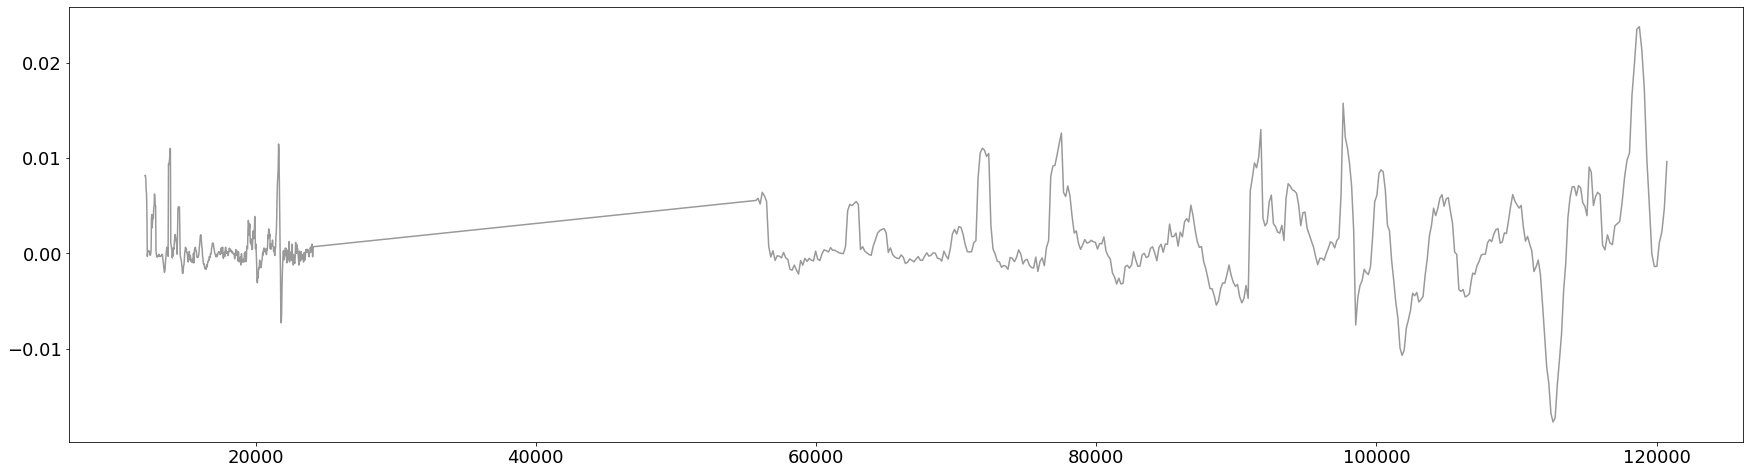

In [44]:
plt.figure(figsize=(30,8))
y.plot(c='grey',alpha=0.8)

In [45]:
y_train_pred = modelo.predict(x_train)
print('Performance do melhor LGBM no treino')
print(mean_absolute_error(y_train,y_train_pred))
# Calculando a métrica no teste
y_test_pred = modelo.predict(x_test)
print('Performance do melhor LGBM no teste')
print(mean_absolute_error(y_test,y_test_pred))

Performance do melhor LGBM no treino
0.0017968753301664234
Performance do melhor LGBM no teste
0.002256206256903311


In [50]:
plt.figure(figsize=(30,6))
y_plot.plot(c='grey',alpha=0.8,linewidth=3) # Dados reais
y_preds.plot(c='blue') # Dados reais
y_mdmv_plot.plot(c='red',alpha=0.5) # Dados reais
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dia',size=22)
plt.ylabel('PM 2.5',size=22)
plt.title('Histórico de PM 2.5 por hora',size=22)
plt.legend(['Dados reais','Modelo LGBM','Média móvel 48h'],fontsize=22)
plt.show()

NameError: name 'y_plot' is not defined

<Figure size 2160x432 with 0 Axes>

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM # Long Short Term Memory
from keras.layers import Bidirectional
from keras.layers import Dropout # Regularização
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping # Regularização

In [ ]:
sc = StandardScaler().fit(x_train)
x_train_sc = sc.transform(x_train).reshape(x_train.shape[0],1,x_train.shape[1])
x_test_sc = sc.transform(x_test).reshape(x_test.shape[0],1,x_test.shape[1])

In [ ]:
# Construindo a estrutura da rede neural
callback = EarlyStopping(monitor='val_loss', patience=3)

model = Sequential() # Vamos construir uma rede sequencial
model.add(
    Bidirectional(LSTM(units=50,input_shape=(x_train_sc.shape[1],x_train_sc.shape[2]))) # Camada LSTM (com memória), bidirecional!
) # Camada de rede neural com memória
model.add(Dropout(rate=0.2)) # Camada de 'esquecimento' de atualização de pesos, para regularização!
model.add(Dense(1)) # Adicionando uma camada que resulta em um output (variável resposta) único
model.compile(loss='mae', optimizer='adam') # Vou minimizar a o MAE, usando a técnica Adam

In [ ]:
# fit network
history = model.fit(
    x_train_sc, y_train, # Dados de treino
    epochs=50, # Número de iterações, i.e., quantas vezes irei atualizar os coeficientes
    batch_size=36, # Tamanho dos dados de entrada a cada iteração
    validation_data=(x_test_sc, y_test), # Dados que o modelo já usará para a validação
    verbose=2, # Forma de apresentar os resultados parciais
    shuffle=False, # Como os dados são temporais, não posso embaralhar!
    callbacks=[callback] # Critérios de parada
)


In [ ]:
# plot history
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Número de épocas (iterações)',size=18)
plt.ylabel('MAE (menor = melhor)',size=18)
plt.title('Evolução da função perda ao longo das iterações da rede neural',size=18)
plt.legend(['Treino','Teste'],fontsize=18)
plt.show()

In [ ]:
y_pred_nn_train = model.predict(x_train_sc)
y_pred_nn_test = model.predict(x_test_sc)

In [ ]:
x_train['pred_nn'] = y_pred_nn_train
x_test['pred_nn'] = y_pred_nn_test
# Prevendo o modelo
y_pred_nn_train = x_train['pred_nn']
y_pred_nn_test = x_test['pred_nn']
# Eliminando colunas auxiliares

In [47]:
!pip install keras

     |████████████████████████████████| 1.6 MB 912 kB/s            


In [49]:
!pip install tensorFlow

     |████████████████████████████████| 458.3 MB 18 kB/s              
     |████████████████████████████████| 1.3 MB 12.3 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 4.0 MB 54.9 MB/s            
     |████████████████████████████████| 65 kB 3.8 MB/s             
     |████████████████████████████████| 132 kB 46.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 462 kB 39.9 MB/s            
     |████████████████████████████████| 57 kB 6.2 MB/s             
     |████████████████████████████████| 42 kB 1.2 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 1.1 MB 26.1 MB/s            
     |████████████████████████████████| 4.5 MB 60.5 MB/s            
     |████████████████████████████████| 5.6 MB 4.3 MB/s            
     |████████████████████████████████| 97 kB 5.0 MB/s             
  Using cached setuptools-59.6.0-py3-none-any.whl (9

      Successfully uninstalled six-1.16.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 39.0.1
    Uninstalling setuptools-39.0.1:
      Successfully uninstalled setuptools-39.0.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0


In [ ]:
avaliacao = {}
for nome,model in modelos.items():
    # Avalia a crossvalidação
    score = cross_val_score(model, # Escolhendo o nosso modelo da vez
                            X_train, y_train, # Nossos dados, excluindo o teste
                            cv=TimeSeriesSplit(n_splits=30), # Validação cruzada temporal
                            scoring='neg_mean_absolute_error', # Usando a métrica MAE
                           n_jobs=8 # Número de processadores, para ser mais rápido
                           ).mean() # Tirando a média de todos os folds
    avaliacao[nome] = -score # -score e não score para tornar o número positivo

In [ ]:
avaliacao

In [ ]:
plt.figure(figsize=(10,5))
plt.barh(*zip(*avaliacao.items()))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('MAE (menor = melhor)',size=18)
plt.show()

In [ ]:
#from datetime import datetime, timedelta
#novo['Dias_analise']=(novo['DATA FINAL'] - novo['DATA INICIAL']) / timedelta(days=1)

In [ ]:
novo['Dias_analise'].value_counts()

In [ ]:
novo['Dias_analise'].head()